In [1]:
import pandas as pd
import numpy as np

with open("./data/causal_inference.txt", 'r') as f:
    text = f.readlines()

res = []
for t in text:
    res.append(list(map(int, t.strip('\n').split(" ")[:-1]))) # 最後空文字が入っている。
#     print(t.strip('\n').split(" ")[:-1])

In [2]:
ds = pd.DataFrame(res)
ds.columns = ["arm", "reward"] + [f"feat_{i}" for i in range(100)]

In [3]:
X = ds.loc[:, "feat_0":].values
y = ds.loc[:, "reward"].values
arms = ds.loc[:,"arm"].values

In [4]:
from src.Arms import ContextualArms
Arms = ContextualArms(
    n_action=10, 
    max_n_sim=100, 
    X=X, 
    y=y,
    ds=ds,
    arms=arms, 
    n_features=X.shape[1], 
    is_logit=False)

In [5]:
Arms.draw()
Arms.get_reward(1)

26.782077393075355

In [6]:
Arms.best_arms()

(2, 26.782077393075355)

In [7]:
d = 100
sigma=1; sigma_0=1
A_inv =sigma_0/sigma * np.eye(d); A_inv
b_t = np.zeros((d, 1))
alpha = 0.05
n_arms = 10
n_sim = 10000
# history = []
history = dict(chosen_arms=[],rewards=[], regrets=[])

In [ ]:
mu_hat = np.zeros((n_arms, 1))

# LinUCBアルゴリズム
for t in range(1, n_sim):
    
    # 3.
    theta = A_inv@b_t 
    # calc alpha_t
    alpha_t = alpha*np.sqrt(np.log(t))
    # 4. A[t]はa_itの転置ver
    
    # 各行動で以下のUCB scoreを計算する。
    # 各アームの特徴量を引く
    # shape : (10, 1, 100) 10 arms, (1, 100)の特徴量ベクトル
    # 1次元目にアーム１から10までの特徴量を順番に格納している。
    A_ = Arms.draw()
    for i in range(n_arms):
        mu_hat[i] = np.dot(A_[i], theta) + alpha_t*sigma*np.sqrt(A_[i]@A_inv@A_[i].T)
    i_star = mu_hat.argmax(0)[0]
    history["chosen_arms"].append(i_star)
    
    #5. スコア最大の行動 i*　を選択して報酬を観測する。
    reward = Arms.get_reward(index=i_star)
    history["rewards"].append(reward)
    # calculate regret
    num_arm, best_reward = Arms.best_arms()
    history["regrets"].append(best_reward - reward)

    a_is = A_[i_star, np.newaxis]
    #6.  A-inverse/ bの更新をする。
    second_term = (A_inv@a_is.T@a_is@A_inv) / (1+a_is@A_inv@a_is.T)
    A_inv = A_inv - second_term
    b_t += a_is.T*reward    

In [ ]:
import seaborn as sns
# sns.regplot(x=np.arange(len(history["regrets"])), y=history["regrets"])

In [ ]:
pd.DataFrame(history["regrets"]).cumsum().plot()

In [8]:
from src.Algorithms import EpsilonGreedy, UCB1

In [12]:
algo1 = EpsilonGreedy(0.1, [], [])
# algo2 = Softmax(1.0, [], [])
# algo3 = UCB1([], [])
# algo4 = Exp3(0.2, [])

algos = [algo1,
#          algo2, algo3, algo4
        ]
algos = {
    "e-greedy":EpsilonGreedy(0.1, [], []),
    "UCB":UCB1([], [])
        }


for algo_name, algo in algos.items():
    algo.initialize(n_arms=10)

history = {algo_name:dict(chosen_arms=[],rewards=[], regrets=[]) for algo_name in algos.keys()}

for t in range(1000):
    for algo_name, algo in algos.items():
        arms =  Arms.draw()
        chosen_arm = algo.select_arm()
        reward = Arms.get_reward(index=chosen_arm)
        num_arm, best_reward = Arms.best_arms()
        history[algo_name]["regrets"].append(best_reward - reward)
        algo.update(chosen_arm, reward)

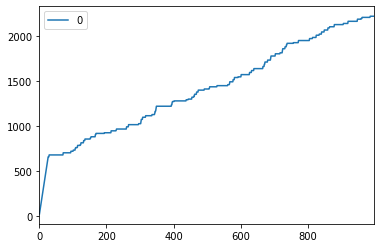

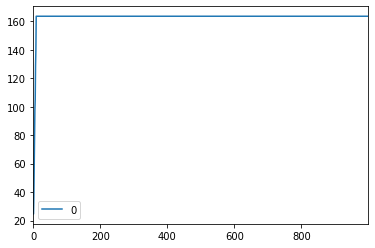

In [13]:
# regret visualization
pd.DataFrame(history["e-greedy"]["regrets"]).cumsum().plot()
pd.DataFrame(history["UCB"]["regrets"]).cumsum().plot()